In [1]:
import rioxarray as rxr
import rasterio as rio
import geopandas as gpd
import xarray as xr
from geocube.api.core import make_geocube
import os
import asyncio
from sqlalchemy.ext.asyncio import create_async_engine
from sqlalchemy.engine import URL
from sqlalchemy.sql import text
from dotenv import load_dotenv

In [2]:
os.chdir("/app")

In [3]:
load_dotenv()
env_vars = os.environ

table_name = "vantaa_luke_mvmi2017_segmpuustonhiili10kgha"

In [4]:
zone = gpd.read_file('data/vantaa_yk.shp')

In [5]:
zone.geometry.unary_union.area

240584715.21879423

In [6]:
zone.head()

,id,geom_type,kt,merkinta,yleiskaava,priority,taso,geometry
0,99,area,KM,KM - Kaupallisten palvelujen alue,Yleiskaava 2007,4,ktalue,"POLYGON ((25489760.098 6684987.869, 25489832.2..."
1,95,area,SL,SL - Luonnonsuojelualue,Yleiskaava 2007,4,ktalue,"POLYGON ((25494897.674 6690792.060, 25495007.4..."
2,97,area,T,T - Teollisuus- ja varastoalue,Yleiskaava 2007,4,ktalue,"POLYGON ((25490703.545 6685562.772, 25490715.2..."
3,75,area,VL,VL - Lähivirkistysalue,Yleiskaava 2007,4,ktalue,"POLYGON ((25492968.537 6684590.761, 25493046.5..."
4,77,area,KM,KM - Kaupallisten palvelujen alue,Yleiskaava 2007,4,ktalue,"POLYGON ((25489579.038 6685037.099, 25489645.1..."


In [7]:
zone["merkinta"].unique()

array(['KM - Kaupallisten palvelujen alue', 'SL - Luonnonsuojelualue',
       'T - Teollisuus- ja varastoalue', 'VL - Lähivirkistysalue',
       'A4 - Pientaloalue', 'C - Keskustatoimintojen alue',
       'A3 - Pientaloalue', 'TP - Työpaikka-alue', 'P1 - Palvelujen alue',
       'P2 - Palvelujen alue',
       'VU - Urheilu- ja virkistyspalvelujen alue',
       'ET - Yhdyskuntateknisen huollon alue', 'W - Vesialue',
       'AT - Kyläalue', 'A1 - Tehokas asuntoalue',
       'PY - Julkisten palvelujen ja hallinnon alue',
       'RA - Loma-asuntoalue',
       'TY - Teollisuusalue, jolla ympäristö asettaa toiminnan laadulle erityisiä vaikutuksia',
       'M - Maa- ja metsätalousvaltainen alue', 'MT - Maatalousalue',
       'A2 - Matala- ja tiivis asuntoalue',
       'T/tk - Teollisuus- ja varastoalue', 'EV - Suojaviheralue',
       'TT - Ympäristövaikutuksiltaan merkittävien teollisuustoimintojen alue',
       'LL - Lentoliikenteen alue', 'VR - Retkeily- ja ulkoilualue',
       'A3/tp - Pie

In [8]:
zone["kt"].unique()

array(['KM', 'SL', 'T', 'VL', 'A4', 'C', 'A3', 'TP', 'P1', 'P2', 'VU',
       'ET', 'W', 'AT', 'A1', 'PY', 'RA', 'TY', 'M', 'MT', 'A2', 'T/tk',
       'EV', 'TT', 'A2/m', 'LL', 'VR', 'A3/tp', 'LR', 'A1/tp', 'W-N',
       'A1/m', 'L', 'EJ', 'RA1', 'EM', 'EH', 'A/TP'], dtype=object)

In [9]:
zone["factor"] = 1

<AxesSubplot: >

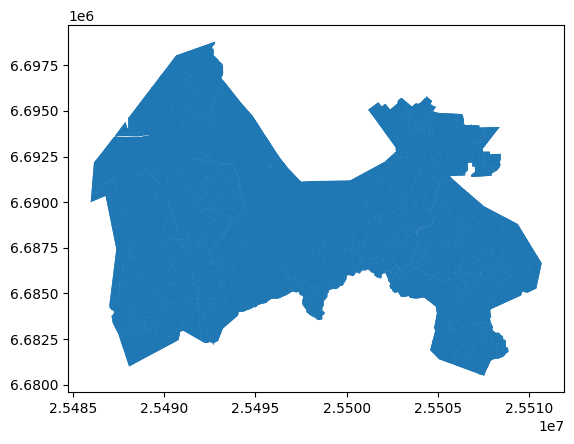

In [10]:
zone.plot()

In [11]:
zone.crs

<Derived Projected CRS: EPSG:3879>
Name: ETRS89 / GK25FIN
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Finland - nominally onshore between 24°30'E and 25°30'E but may be used in adjacent areas if a municipality chooses to use one zone over its whole extent.
- bounds: (24.5, 59.94, 25.5, 68.9)
Coordinate Operation:
- name: Finland Gauss-Kruger zone 25
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [12]:
wkt = zone.geometry.unary_union.wkt

In [13]:
url_object = URL.create(
    "postgresql+asyncpg",
    username=env_vars["PG_USER"],
    password=env_vars["PG_PASSWORD"],
    host="localhost",
    database=env_vars["PG_DB"],
    port=env_vars["PG_PORT"],
)


In [14]:
engine = create_async_engine(
    url_object,
    echo=True,
)


async def fetch_rasters_for_region(wkt, crs):
    async with engine.connect() as conn:
        # select a Result, which will be delivered with buffered
        # results
        await conn.execute(text("SET postgis.gdal_enabled_drivers TO 'GTiff';"))
        
        statement = text(
            f"""
                SELECT
                ST_AsTIFF(ST_Union(rast), 'LZW') as tiff
                FROM vantaa_luke_mvmi2017_segmpuustonhiili10kgha
                WHERE ST_Intersects(
                rast, 
                ST_Transform(
                    ST_SetSRID(
                        ST_GeomFromText(
                            :wkt
                        ), 
                        :crs
                    ), 
                    3067
                )
                );
            """
        )
        result = await conn.execute(statement, {"wkt": wkt, "crs": crs})

        return result.fetchall()


await engine.dispose()
# for AsyncEngine created in function scope, close and
# clean-up pooled connections


In [15]:
test_poly='POLYGON((375344 6698336,375600 6698336,375600 6698080,375344 6698080,375344 6698336))'

In [16]:
asdf = await fetch_rasters_for_region(wkt=wkt, crs=3879)

2022-12-18 21:01:04,116 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2022-12-18 21:01:04,118 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-18 21:01:04,247 INFO sqlalchemy.engine.Engine select current_schema()
2022-12-18 21:01:04,248 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-18 21:01:04,410 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2022-12-18 21:01:04,411 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-18 21:01:04,555 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-18 21:01:04,556 INFO sqlalchemy.engine.Engine SET postgis.gdal_enabled_drivers TO 'GTiff';
2022-12-18 21:01:04,558 INFO sqlalchemy.engine.Engine [generated in 0.00234s] ()
2022-12-18 21:01:04,718 INFO sqlalchemy.engine.Engine 
                SELECT
                ST_AsTIFF(ST_Union(rast), 'LZW') as tiff
                FROM vantaa_luke_mvmi2017_segmpuustonhiili10kgha
                WHERE ST_Intersects(
                rast, 
                ST_Transform(
           

In [30]:
rast = asdf[0][0]
with rio.MemoryFile(rast).open() as dataset:
    carbon = rxr.open_rasterio(dataset)
    

In [ ]:
# arbon = rxr.open_rasterio('data/carbon_2022-11-01.tif')

In [17]:
zone_raster = make_geocube(zone, resolution=(-16, 16), measurements=["factor"], output_crs="EPSG:3067")


In [32]:
# no data is 32766, non-forest is 32767
carbon = carbon.where(carbon < 32766)

In [33]:
print(carbon)

<xarray.DataArray (band: 1, y: 1184, x: 1552)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 3.754e+05 3.754e+05 ... 4.002e+05 4.002e+05
  * y            (y) float64 6.698e+06 6.698e+06 ... 6.679e+06 6.679e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     32766
    scale_factor:   1.0
    add_offset:     0.0


In [22]:
# unit is 10 kg c / ha
# convert to kg / grid cell, where cell size is 16x16

ha_to_grid = 16 * 16 / 10000
grid_to_ha = 1 / ha_to_grid


In [23]:
carbon = carbon * ha_to_grid

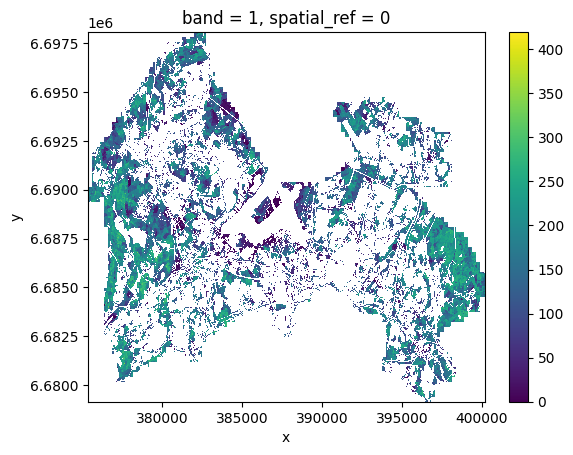

In [24]:
carbon.plot()

In [25]:
print(zone_raster)

<xarray.Dataset>
Dimensions:      (y: 1170, x: 1537)
Coordinates:
  * y            (y) float64 6.698e+06 6.698e+06 ... 6.679e+06 6.679e+06
  * x            (x) float64 3.755e+05 3.755e+05 ... 4.001e+05 4.001e+05
    spatial_ref  int64 0
Data variables:
    factor       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

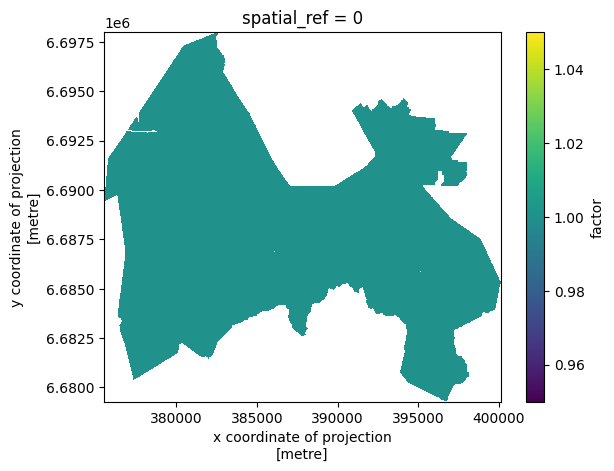

In [60]:
zone_raster["factor"].plot()

In [26]:
carbon_arr = zone_raster["factor"] * carbon

In [27]:
carbon_arr.sum(skipna=True)

<xarray.DataArray ()>
array(57914465.51039997)
Coordinates:
    spatial_ref  int64 0

In [100]:
carbon_arr.sum(skipna=True)

<xarray.DataArray ()>
array(57914465.51039997)
Coordinates:
    spatial_ref  int64 0